# Introduction
This notebook is `Chexmix` tutorial.  
The key concept of Chexmix is getting various information from `Keyword`.  
  
[Chexmix paper]('https://www.nature.com/articles/s41598-022-12093-9')
## Contents
- how to build graphs
- how to combine graphs
- how to build subgraph
- how to build Chexmix graph


In [1]:
%load_ext autoreload
%autoreload 2

import json
import pickle
import networkx as nx
from chexmix.datasources import mesh, taxonomy

from chexmix.graph import BioGraph,TaxonomyGraph, MeSHGraph, PubTatorGraph, PubMedGraph, TaxParentType, NodeType, EdgeType

from chexmix.utils import remove_symbols

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## KPEB data load
with open('../data/KPEB/KPEB_name_taxID.json', 'r') as f:
    kpeb_data = json.load(f)
kpeb_data = {int(k): v for k,v in kpeb_data.items()}

##viridiplantae load
with open('../data/viridiplanae.txt', 'rb') as f:
    viridiplantae = pickle.load(f)

In [3]:
# graph save directory path
path = '../data/network/'

In [4]:
# Set division point hierarchical Taxonomy (Genus or Family)
parent_node_type = TaxParentType.Genus

In [5]:
def draw_graph(g):
    nx.draw(g, with_labels=True, connectionstyle="arc3,rad=-0.3")

# How to build graphs

In [6]:
# pubmed graph using keyword
keyword = 'cynandione A' # put keyword

pubmed_graph = PubMedGraph.from_keyword(keyword)
article_ids = pubmed_graph.get_article_ids()

[42345] INFO: search pubmed: cynandione A
/home/bionuser/.conda/envs/bionlab/lib/python3.9/site-packages/Bio/Entrez/__init__.py:686: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  warnings.warn(
[42345] INFO: total count: 23


  0%|          | 0/1 [00:00<?, ?it/s]

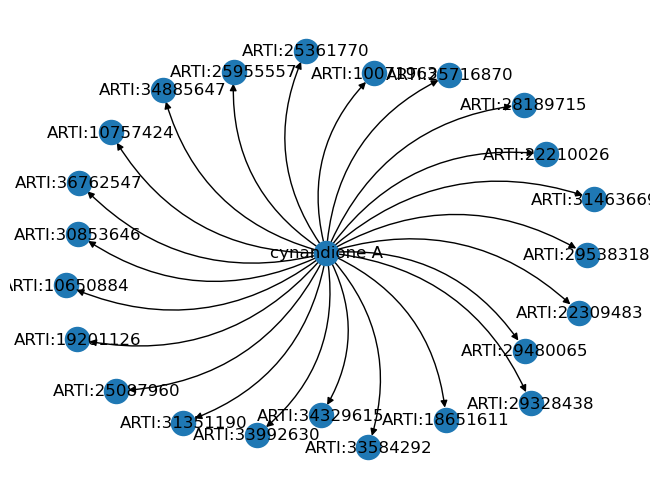

In [7]:
draw_graph(pubmed_graph)

In [8]:
# pubtator graph 
pubtator_graph = PubTatorGraph.from_article_ids(article_ids)

  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# taxonomy graph
tax_table = taxonomy.load_taxonomy()
tax_raw_graph = TaxonomyGraph.from_table(tax_table)
tax_bioentities = pubtator_graph.get_bioentities(['TAXO'])
tax_graph = tax_raw_graph.subgraph_from_pubtator_bioentities(tax_table,parent_node_type, tax_bioentities, viridiplantae, 'KPEB', kpeb_data)

[42345] INFO: load /home/bionuser/bionlab/external/chexmix/data/taxonomy.pkl


In [10]:
# mesh graph
mesh_table = mesh.load_mesh()
mesh_raw_graph = MeSHGraph.from_table(mesh_table)
mesh_bioentities = pubtator_graph.get_bioentities(['MSHD','MSHC'])
mesh_graph = mesh_raw_graph.subgraph_from_pubtator_bioentities(mesh_bioentities)

[42345] INFO: load /home/bionuser/bionlab/external/chexmix/data/mesh.pkl


In [11]:
# if you want to see nodes and edges data, run below codes
# graph.nodes(data=True)
# graph.edges(data=True)
list(tax_graph.nodes(data=True))[0]

('TAXO:59171',
 {'id': 'TAXO:59171',
  'raw_id': 59171,
  'type': 'Taxonomy',
  'rank': 'genus',
  'name': 'Patrinia',
  'parent_id': 'TAXO:4200',
  'family': 'Caprifoliaceae',
  'genus': '',
  'level': 48,
  'lineage': ['TAXO:131567',
   'TAXO:2759',
   'TAXO:33090',
   'TAXO:35493',
   'TAXO:131221',
   'TAXO:3193',
   'TAXO:58023',
   'TAXO:78536',
   'TAXO:58024',
   'TAXO:3398',
   'TAXO:1437183',
   'TAXO:71240',
   'TAXO:91827',
   'TAXO:1437201',
   'TAXO:71274',
   'TAXO:91882',
   'TAXO:4199',
   'TAXO:4200'],
  'sub_type': 'Genus'})

# How to combine graphs
- using function
    - `graph.union(other_graph)`
    - `graph.intersection(other_graph)`

In [12]:
union_graph = pubtator_graph.union(tax_graph)
# intersect() only represent intersect nodes
intersect_graph = pubtator_graph.intersection(mesh_graph)

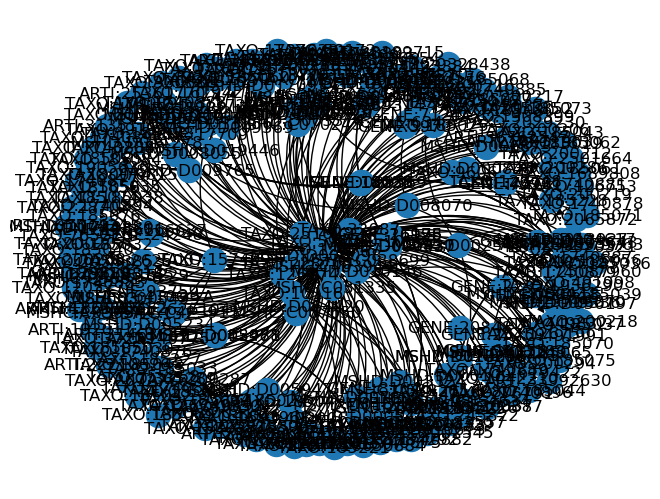

In [13]:
draw_graph(pubtator_graph.union(tax_graph))

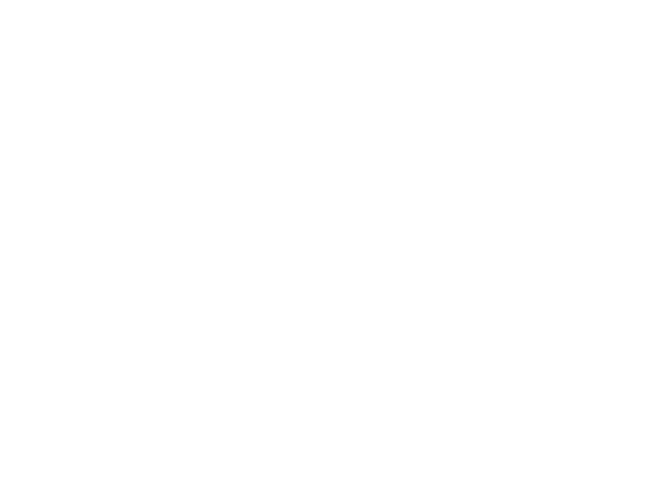

In [14]:
draw_graph(intersect_graph)

# how to build subgraph
sometimes or more, graph is too big and mesh to analysis.
so below codes will help or resolve that situation.
This code's purpose is build a subgraph which is remain specific node types

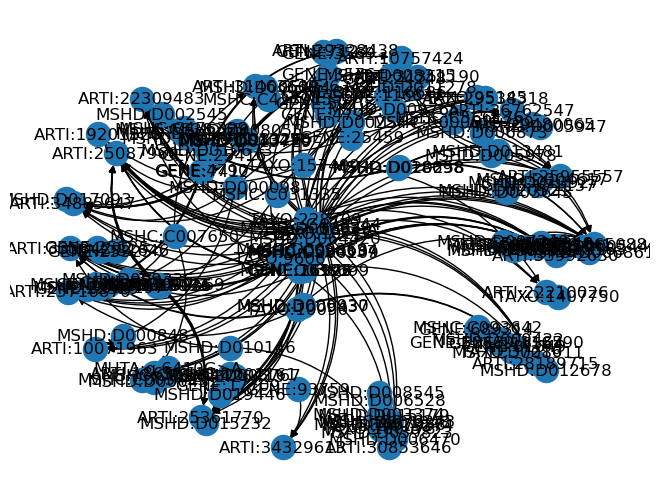

In [15]:
# build whole graph
union_graph2 = pubmed_graph.union(pubtator_graph)
draw_graph(union_graph2)

In [16]:
# only remain NodeType.Gene and get node ids
# put specific node type in `remain_by_node_types([NODETYPE])`
trimmed_pubtator_graph = pubtator_graph.remain_by_node_types([NodeType.Gene])
node_ids =[node_data[0] for node_data in list(trimmed_pubtator_graph.nodes(data=True))]

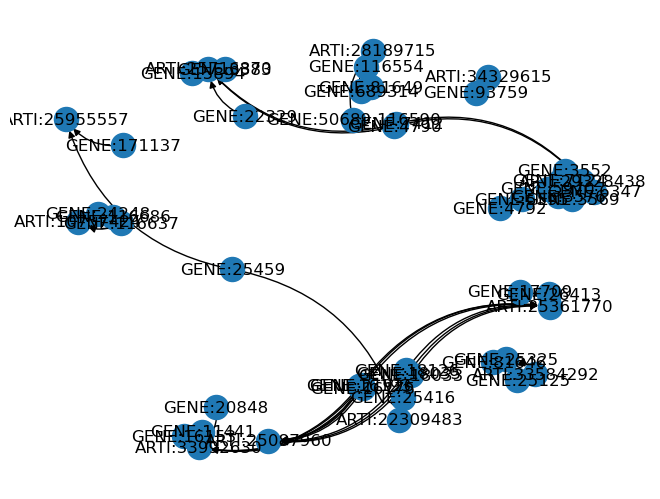

In [17]:
# filtered node and edges from union graph using node ids
filtered_g = union_graph2.subgraph_from_roots(node_ids)
draw_graph(filtered_g)

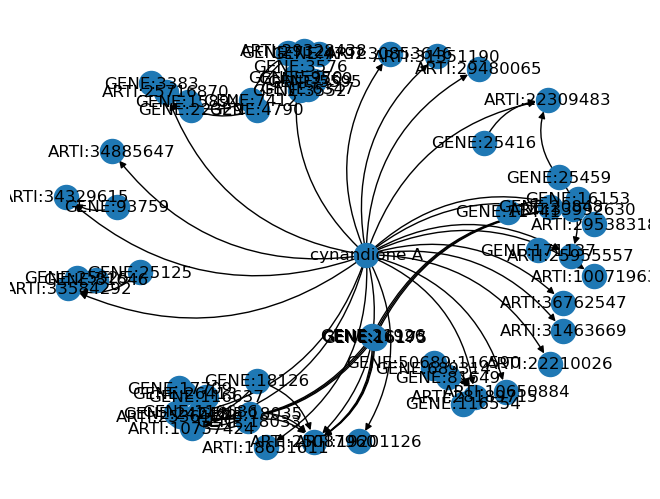

In [18]:
draw_graph(pubmed_graph.union(filtered_g))

# How to build Chexmix graph

In [16]:
input_names = ["cynandione A", "cynanchum wilfordii"]
chexmix_graphs = []

# load table
# tax_table = taxonomy.load_taxonomy()
# mesh_table = mesh.load_mesh()

In [17]:
for input_name in input_names:    
    file_name = path + remove_symbols(input_name)
    # phase 1. build graphs
    pubmed_graph = PubMedGraph.from_keyword(input_name)
    article_ids = pubmed_graph.get_article_ids()
    
    pubtator_graph = PubTatorGraph.from_article_ids(article_ids)

    tax_raw_graph = TaxonomyGraph.from_table(tax_table)
    tax_bioentities = pubtator_graph.get_bioentities(['TAXO'])
    tax_graph = tax_raw_graph.subgraph_from_pubtator_bioentities(tax_table,parent_node_type, tax_bioentities, viridiplantae, 'KPEB', kpeb_data)

    mesh_raw_graph = MeSHGraph.from_table(mesh_table)
    mesh_bioentities = pubtator_graph.get_bioentities(['MSHD','MSHC'])
    mesh_graph = mesh_raw_graph.subgraph_from_pubtator_bioentities(mesh_bioentities)
    
    # phase 2. combine graphs
    chexmix_graph = pubmed_graph.union(pubtator_graph.union(tax_graph).union(mesh_graph))
    # export graph
    # nx.write_graphml(chexmix_graph.to_graphml(), f'{file_name}_chexmix.graphml')
    chexmix_graphs.append(chexmix_graph)

[52724] INFO: search pubmed: cynandione A
/home/bionuser/.conda/envs/bionlab/lib/python3.9/site-packages/Bio/Entrez/__init__.py:686: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  warnings.warn(
[52724] INFO: total count: 23


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[52724] INFO: search pubmed: cynanchum wilfordii
[52724] INFO: total count: 69


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
chexmix_intersection_graph=chexmix_graphs[0].intersection(chexmix_graphs[1])
chexmix_union_graph = chexmix_graphs[0].union(chexmix_graphs[1])

In [ ]:
# export graphs
# nx.write_graphml(intersection_graph.to_graphml(), '../data/network/cynandione_test_intersection.graphml')
# nx.write_graphml(union_graph.to_graphml(), '../data/network/cynandione_test_union.graphml')